<a href="https://www.kaggle.com/code/nigamshitij/fitting-quadratic-equations-with-stacked-relus?scriptVersionId=177012030" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
!pip install fastbook
import fastbook

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.8/719.8 kB 4.1 MB/s eta 0:00:00a 0:00:01m


In [4]:
from fastai.vision.all import plt
# from utils import *
from fastbook import *

10.75
10.75


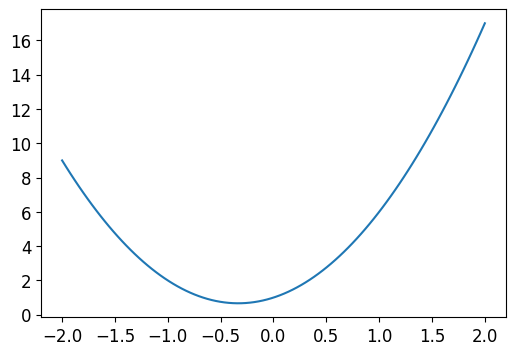

In [5]:
def quad(a, b, c, x):
    return a*x**2 + b*x + c

print(quad(3, 2, 1, 1.5))

from functools import partial
def mk_quad(a, b, c):
    return partial(quad, a, b, c)

f = mk_quad(3, 2, 1)
print(f(1.5))

plot_function(f)

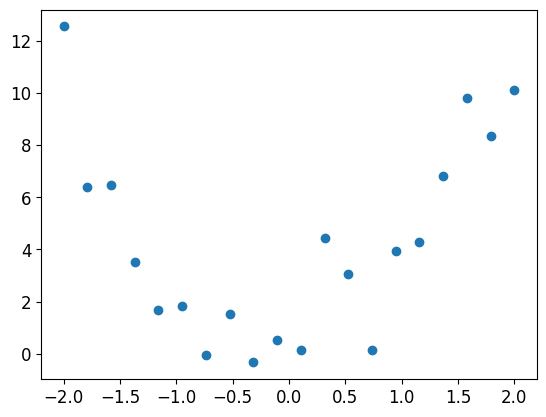

In [6]:
# generate random numbers to fit this graph / shape
from numpy.random import normal, seed, uniform

np.random.seed(42)

def noise(x, scale):
    return normal(scale = scale, size = x.shape)

def add_noise(x, mult_scale, add_scale):
    return x*(1+noise(x, mult_scale)) + noise(x, add_scale)

x = torch.linspace(-2, 2, steps = 20)[:, None]
y = add_noise(f(x), 0.3, 1.5)
plt.scatter(x, y)

# x = torch.linspace(-2, 2, steps = 5)
# print(x, x[:, None])
# print(x.shape, x[:, None].shape)

In [7]:
plot_function??

Signature:
plot_function(
    f,
    tx=None,
    ty=None,
    title=None,
    min=-2,
    max=2,
    figsize=(6, 4),
)
Docstring: <no docstring>
Source:   
def plot_function(f, tx=None, ty=None, title=None, min=-2, max=2, figsize=(6,4)):
    x = torch.linspace(min,max, 100)
    fig,ax = plt.subplots(figsize=figsize)
    ax.plot(x,f(x))
    if tx is not None: ax.set_xlabel(tx)
    if ty is not None: ax.set_ylabel(ty)
    if title is not None: ax.set_title(title)
File:      /opt/conda/lib/python3.10/site-packages/fastbook/__init__.py
Type:      function

In [8]:
from ipywidgets import interact
@interact(a = 1.5, b = 1.5, c = 1.5)
def plot_quad(a, b, c):
    plot_function(mk_quad(a, b, c))
    plt.scatter(x, y)

interactive(children=(FloatSlider(value=1.5, description='a', max=4.5, min=-1.5), FloatSlider(value=1.5, descr…

In [9]:
# loss function
def mse(preds, acts):
    return ((preds-acts)**2).mean()

@interact(a = 1.5, b = 1.5, c = 1.5)
def plot_quad(a, b, c):
    f = mk_quad(a, b, c)
    loss = mse(f(x), y)
    plot_function(f, title = f"MSE: {loss: .2f}")
    plt.scatter(x, y) # adds the 

interactive(children=(FloatSlider(value=1.5, description='a', max=4.5, min=-1.5), FloatSlider(value=1.5, descr…

In [10]:
def quad_mse(params):
    f = mk_quad(*params)
    loss = mse(f(x), y)
    return loss

# rank 1 tensor / 1d tensor
abc = torch.tensor([1.5, 1.5, 1.5])
abc.requires_grad_()

loss = quad_mse(abc)
print("Loss: ", loss)
print("Pre backward grad:", abc.grad)

loss.backward()
print("Post backward grad:", abc.grad)

Loss:  tensor(5.8336, dtype=torch.float64, grad_fn=<MeanBackward0>)
Pre backward grad: None
Post backward grad: tensor([-5.1419,  2.8472, -1.1009])


In [11]:
with torch.no_grad(): # 
    abc -= abc.grad*0.01
    loss = quad_mse(abc)

    print(f'loss = {loss: .2f}')

loss =  5.49


In [12]:
for i in range(5):
    loss = quad_mse(abc)
    loss.backward()
    with torch.no_grad():
        abc -= abc.grad * 0.01
        print(f'step = {i}; loss = {loss:.2f}')

step = 0; loss = 5.49
step = 1; loss = 4.90
step = 2; loss = 4.23
step = 3; loss = 3.67
step = 4; loss = 3.33


In [13]:
torch.clip??

Docstring:
clip(input, min=None, max=None, *, out=None) -> Tensor

Alias for :func:`torch.clamp`.
Type:      builtin_function_or_method

In [14]:
def rectified_linear(m, b, x):
    y = m*x + b
    return torch.clip(y, min = 0.)

# plot_function(partial(rectified_linear, 1, 1), min = -5, max = 5) # m,b set to 1,1

# @interact(m = 1.5, b = 1.5)
def plot_relu(m, b):
    plot_function(partial(rectified_linear, 1,1))

def double_relu(m1, b1, m2, b2, x):
    return rectified_linear(m1,b1,x) + rectified_linear(m2,b2,x)
    
@interact(m1 = -1.5, b1 = -1.5, m2 = 1.5, b2 = 1.5)
def plot_double_relu(m1, b1, m2, b2):
    plot_function(partial(double_relu, m1,b1,m2,b2))

interactive(children=(FloatSlider(value=-1.5, description='m1', max=1.5, min=-4.5), FloatSlider(value=-1.5, de…

In [ ]:
# def titanic():
#     return 0